In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
data_df = pd.read_csv('./rice-type-classification/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
data_df.dropna(inplace=True)
data_df.drop(["id"], axis=1, inplace=True)

data_df.shape

(18185, 11)

In [5]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [6]:
print(data_df["Class"].unique())

[1 0]


In [7]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [8]:
original_df = data_df.copy()

In [9]:
for column in data_df.columns:
    data_df[column] = data_df[column] / max(data_df[column].abs())

In [10]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [11]:
X = np.array(data_df.iloc[:, :-1])
y = np.array(data_df.iloc[:, -1])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)
(12729,)
(2728,)
(2728,)


In [15]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [16]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [17]:
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=8, shuffle=True)

In [18]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output = self.input_layer(x)
        output = self.linear(output)
        output = self.sigmoid(output)

        return output

In [19]:
model = MyModel().to(device)

In [20]:
summary(model, input_size=(X.shape[1],), batch_size=8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [8, 10]             110
            Linear-2                     [8, 1]              11
           Sigmoid-3                     [8, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [21]:
criterion = nn.BCELoss() # Binray Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=1e-3)

In [22]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs, labels = data

        predictions = model(inputs).squeeze(1)

        batch_loss = criterion(predictions, labels)

        total_loss_train += batch_loss.item()

        acc = ((predictions).round() == labels).sum().item()
        
        total_acc_train += acc

        batch_loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            predictions = model(inputs).squeeze(1)

            batch_loss = criterion(predictions, labels)

            total_loss_val += batch_loss.item()

            acc = ((predictions))

            acc = ((predictions).round() == labels).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

    print(f"""Epoch no. {epoch + 1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)}
            Validation Loss: {round(total_loss_val/1000, 4)} Validation Accuracy: {round(total_acc_val/validation_data.__len__() * 100, 4)}""")
    
    print("=" * 25)

Epoch no. 1 Train Loss: 0.6055 Train Accuracy: 93.3852
            Validation Loss: 0.0488 Validation Accuracy: 98.0205
Epoch no. 2 Train Loss: 0.1383 Train Accuracy: 98.4288
            Validation Loss: 0.0243 Validation Accuracy: 98.2405
Epoch no. 3 Train Loss: 0.0852 Train Accuracy: 98.6409
            Validation Loss: 0.0188 Validation Accuracy: 98.4604
Epoch no. 4 Train Loss: 0.0724 Train Accuracy: 98.6566
            Validation Loss: 0.0175 Validation Accuracy: 98.4604
Epoch no. 5 Train Loss: 0.0673 Train Accuracy: 98.6723
            Validation Loss: 0.0172 Validation Accuracy: 98.5337
Epoch no. 6 Train Loss: 0.0659 Train Accuracy: 98.6645
            Validation Loss: 0.0188 Validation Accuracy: 98.3504
Epoch no. 7 Train Loss: 0.0637 Train Accuracy: 98.688
            Validation Loss: 0.0183 Validation Accuracy: 98.3871
Epoch no. 8 Train Loss: 0.0634 Train Accuracy: 98.6802
            Validation Loss: 0.0166 Validation Accuracy: 98.3871
Epoch no. 9 Train Loss: 0.0639 Train Accu

In [23]:
with torch.no_grad():
   total_loss_test = 0
   total_acc_test = 0

   for data in test_dataloader:
      inputs, labels = data

      predictions = model(inputs).squeeze(1)

      batch_loss_test = criterion(predictions, labels).item()

      total_loss_test += batch_loss_test

      acc = ((predictions).round() == labels).sum().item()

      total_acc_test += acc

In [24]:
print(f"Accurary :{round(total_acc_test/testing_data.__len__() * 100, 4)}")

Accurary :98.5704


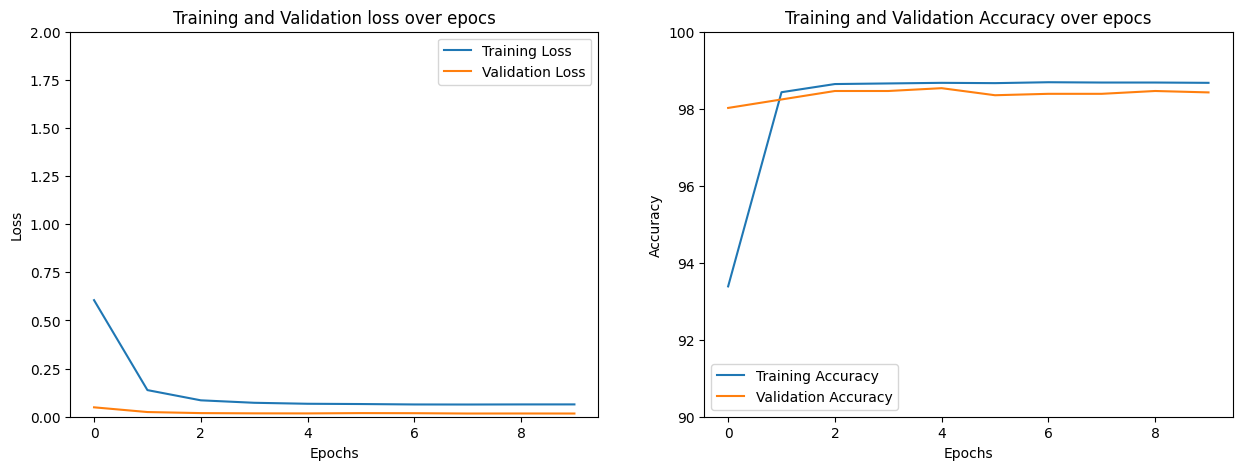

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label="Training Loss")
axs[0].plot(total_loss_validation_plot, label="Validation Loss")
axs[0].set_title("Training and Validation loss over epocs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Training Accuracy")
axs[1].plot(total_acc_validation_plot, label="Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over epocs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

axs[1].set_ylim([90,100])
axs[1].legend()

plt.show()